In [0]:
from pyspark.sql.types import *
from pyspark.sql.functions import *
import matplotlib.pyplot as plt

## 1.1

### 1.1.1

In [0]:
txn = spark.read.format('csv')\
.option('header', 'true')\
.option('inferSchema', 'true')\
.load('/FileStore/tables/Retail_Data_Transactions.csv')\
.coalesce(5)
txn.cache()
txn.createOrReplaceTempView("txnTable")

In [0]:
txn.count()

Out[210]: 125000

The number of rows is 125000.

### 1.1.2

In [0]:
txn = txn.select(col('customer_id'), to_date(col('trans_date'), 'dd-MMM-yy').alias('txn_date'), 'tran_amount')

### 1.1.3

In [0]:
txn.select(min('txn_date'), max('txn_date')).show()

+-------------+-------------+
|min(txn_date)|max(txn_date)|
+-------------+-------------+
|   2011-05-16|   2015-03-16|
+-------------+-------------+



### 1.1.4 & 1.1.5

In [0]:
txn = txn.select('customer_id', 'tran_amount', 'txn_date', last_day(txn.txn_date).alias('ME_DT'), year("txn_date").alias('YEAR'))

In [0]:
# Check the snapshot
txn.collect()[55:60]

Out[214]: [Row(customer_id='CS2662', tran_amount=88, txn_date=datetime.date(2014, 8, 31), ME_DT=datetime.date(2014, 8, 31), YEAR=2014),
 Row(customer_id='CS2209', tran_amount=35, txn_date=datetime.date(2012, 3, 12), ME_DT=datetime.date(2012, 3, 31), YEAR=2012),
 Row(customer_id='CS4530', tran_amount=40, txn_date=datetime.date(2011, 6, 5), ME_DT=datetime.date(2011, 6, 30), YEAR=2011),
 Row(customer_id='CS2848', tran_amount=53, txn_date=datetime.date(2013, 2, 4), ME_DT=datetime.date(2013, 2, 28), YEAR=2013),
 Row(customer_id='CS2596', tran_amount=55, txn_date=datetime.date(2011, 9, 19), ME_DT=datetime.date(2011, 9, 30), YEAR=2011)]

## 1.2

### 1.2.1

In [0]:
clnt_annual_aggregations = txn.groupBy('customer_id', 'YEAR').agg(sum('tran_amount').alias('ann_txn_amt_sum'),
                                      mean('tran_amount').alias('ann_txn_amt_ave'),
                                      stddev_samp('tran_amount').alias('ann_txn_amt_std'),
                                      var_samp('tran_amount').alias('ann_txn_amt_var'),
                                      (stddev_samp('tran_amount') / sqrt(count('tran_amount'))).alias('ann_txn_sem'),
                                      max('tran_amount').alias('ann_txn_max'),
                                      min('tran_amount').alias('ann_txn_min'),
                                      count('tran_amount').alias('ann_txn_cnt')).orderBy(txn.customer_id.asc(), txn.YEAR.asc())

In [0]:
# Check snapshot
clnt_annual_aggregations.show()

+-----------+----+---------------+-----------------+------------------+------------------+------------------+-----------+-----------+-----------+
|customer_id|YEAR|ann_txn_amt_sum|  ann_txn_amt_ave|   ann_txn_amt_std|   ann_txn_amt_var|       ann_txn_sem|ann_txn_max|ann_txn_min|ann_txn_cnt|
+-----------+----+---------------+-----------------+------------------+------------------+------------------+-----------+-----------+-----------+
|     CS1112|2011|            212|70.66666666666667| 22.03028218914441|485.33333333333337|12.719189352225943|         96|         56|          3|
|     CS1112|2012|            337|             67.4|12.720062892926277|             161.8| 5.688585061331157|         81|         52|          5|
|     CS1112|2013|            212|70.66666666666667| 34.50120770833006|1190.3333333333333| 19.91928155777155|        105|         36|          3|
|     CS1112|2014|            212|70.66666666666667|16.862186493255653|284.33333333333337| 9.735387911006823|         90|   

### 1.2.2

Out[217]: (array([3.984e+03, 5.191e+03, 4.940e+03, 4.138e+03, 3.562e+03, 2.989e+03,
        2.243e+03, 1.651e+03, 1.082e+03, 6.570e+02, 3.330e+02, 1.890e+02,
        9.400e+01, 5.000e+01, 2.100e+01, 1.000e+01, 1.000e+00, 1.000e+00,
        3.000e+00, 1.000e+00]),
 array([  10.  ,   75.35,  140.7 ,  206.05,  271.4 ,  336.75,  402.1 ,
         467.45,  532.8 ,  598.15,  663.5 ,  728.85,  794.2 ,  859.55,
         924.9 ,  990.25, 1055.6 , 1120.95, 1186.3 , 1251.65, 1317.  ]),
 <BarContainer object of 20 artists>)

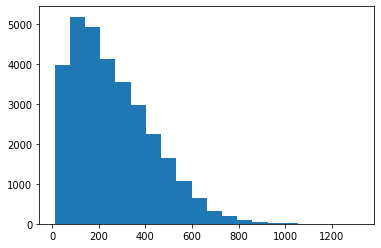

In [0]:
bins, counts = clnt_annual_aggregations.select('ann_txn_amt_sum').rdd.flatMap(lambda x: x).histogram(20)
plt.hist(bins[:-1], bins=bins, weights=counts)

Out[218]: (array([4.587e+03, 4.908e+03, 5.023e+03, 4.798e+03, 4.107e+03, 3.085e+03,
        2.076e+03, 1.278e+03, 7.000e+02, 3.110e+02, 1.510e+02, 7.000e+01,
        3.300e+01, 6.000e+00, 4.000e+00, 1.000e+00, 1.000e+00, 1.000e+00]),
 array([ 1.        ,  1.94444444,  2.88888889,  3.83333333,  4.77777778,
         5.72222222,  6.66666667,  7.61111111,  8.55555556,  9.5       ,
        10.44444444, 11.38888889, 12.33333333, 13.27777778, 14.22222222,
        15.16666667, 16.11111111, 17.05555556, 18.        ]),
 <BarContainer object of 18 artists>)

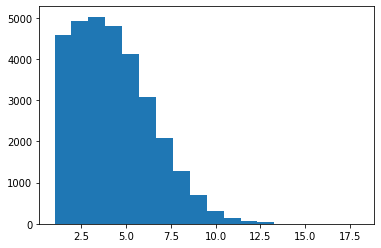

In [0]:
bins, counts = clnt_annual_aggregations.select('ann_txn_cnt').rdd.flatMap(lambda x: x).histogram(18)
plt.hist(bins[:-1], bins=bins, weights=counts)

### 1.2.3

In [0]:
clnt_annual_aggregations_pivot = txn.groupBy('customer_id').pivot('YEAR').agg(sum('tran_amount').alias('ann_txn_amt_sum'),
                                                  mean('tran_amount').alias('ann_txn_amt_ave'),
                                                  stddev_samp('tran_amount').alias('ann_txn_amt_std'),
                                                  var_samp('tran_amount').alias('ann_txn_amt_var'),
                                                  (stddev_samp('tran_amount') / sqrt(count('tran_amount'))).alias('ann_txn_sem'),
                                                  max('tran_amount').alias('ann_txn_max'),
                                                  min('tran_amount').alias('ann_txn_min'),
                                                  count('tran_amount').alias('ann_txn_cnt'))
clnt_annual_aggregations_pivot = clnt_annual_aggregations_pivot.orderBy(clnt_annual_aggregations_pivot.customer_id.asc()).fillna(0)

I filled NaN values with 0. Since we are aggregating annual spending, and there are some cases where one didn't spend on the particular year. It is sensible because for example, the last day of this dataset is 2015-03-16, so it could be that people haven't spend any money at this time of the year. Also, it is not appropriate if we fill the value based on other values, since then we are saying one has spent money in that year, which is not the case.

### 1.2.4

In [0]:
clnt_annual_aggregations_pivot.display()

customer_id,2011_ann_txn_amt_sum,2011_ann_txn_amt_ave,2011_ann_txn_amt_std,2011_ann_txn_amt_var,2011_ann_txn_sem,2011_ann_txn_max,2011_ann_txn_min,2011_ann_txn_cnt,2012_ann_txn_amt_sum,2012_ann_txn_amt_ave,2012_ann_txn_amt_std,2012_ann_txn_amt_var,2012_ann_txn_sem,2012_ann_txn_max,2012_ann_txn_min,2012_ann_txn_cnt,2013_ann_txn_amt_sum,2013_ann_txn_amt_ave,2013_ann_txn_amt_std,2013_ann_txn_amt_var,2013_ann_txn_sem,2013_ann_txn_max,2013_ann_txn_min,2013_ann_txn_cnt,2014_ann_txn_amt_sum,2014_ann_txn_amt_ave,2014_ann_txn_amt_std,2014_ann_txn_amt_var,2014_ann_txn_sem,2014_ann_txn_max,2014_ann_txn_min,2014_ann_txn_cnt,2015_ann_txn_amt_sum,2015_ann_txn_amt_ave,2015_ann_txn_amt_std,2015_ann_txn_amt_var,2015_ann_txn_sem,2015_ann_txn_max,2015_ann_txn_min,2015_ann_txn_cnt
CS1112,212,70.66666666666667,22.03028218914441,485.33333333333337,12.719189352225943,96,56,3,337,67.4,12.720062892926277,161.8,5.688585061331157,81,52,5,212,70.66666666666667,34.50120770833006,1190.3333333333333,19.91928155777155,105,36,3,212,70.66666666666667,16.862186493255653,284.33333333333337,9.735387911006823,90,59,3,39,39.0,0.0,0.0,0.0,39,39,1
CS1113,244,81.33333333333333,21.07921567168317,444.33333333333337,12.170090842352456,94,57,3,374,74.8,17.035257556021865,290.20000000000005,7.618398781896364,95,51,5,426,85.2,13.0843417870369,171.2,5.851495535331117,97,65,5,226,56.5,27.958302285129307,781.6666666666666,13.979151142564653,97,36,4,220,73.33333333333333,27.300793639257694,745.3333333333334,15.762120556715853,98,44,3
CS1114,426,85.2,9.731392500562293,94.70000000000003,4.352011029397789,97,76,5,150,75.0,31.11269837220809,968.0,21.999999999999996,97,53,2,352,70.4,24.88573888796553,619.3,11.129240764760189,105,43,5,425,70.83333333333333,26.947479783212874,726.1666666666666,11.001262553806166,95,37,6,79,79.0,0.0,0.0,0.0,79,79,1
CS1115,261,87.0,15.0,225.0,8.660254037844387,102,72,3,473,67.57142857142857,21.846869667888676,477.2857142857143,8.257340580924813,104,41,7,557,79.57142857142857,10.533393610436333,110.95238095238098,3.9812485649673297,94,66,7,313,78.25,22.632940595512547,512.2499999999999,11.316470297756274,98,50,4,55,55.0,0.0,0.0,0.0,55,55,1
CS1116,235,58.75,21.203380233664003,449.5833333333333,10.601690116832001,87,41,4,230,76.66666666666667,30.138568866708543,908.3333333333334,17.400510848184254,105,45,3,59,59.0,0.0,0.0,0.0,59,59,1,333,66.6,25.234896472940004,636.8,11.285388783732706,96,40,5,0,0.0,0.0,0.0,0.0,0,0,0
CS1117,213,71.0,26.057628441590765,679.0,15.044378795195678,98,46,3,196,65.33333333333333,32.715949219506584,1070.3333333333335,18.888562088676252,100,35,3,347,69.4,17.38677658451963,302.30000000000007,7.775602870517502,94,49,5,429,71.5,15.871357849913158,251.9,6.47945470956726,94,56,6,0,0.0,0.0,0.0,0.0,0,0,0
CS1118,124,62.0,26.870057685088806,722.0,19.0,81,43,2,63,63.0,0.0,0.0,0.0,63,63,1,144,72.0,7.0710678118654755,50.0,5.0,77,67,2,620,68.88888888888889,23.5661008890124,555.3611111111111,7.855366963004133,101,41,9,60,60.0,0.0,0.0,0.0,60,60,1
CS1119,0,0.0,0.0,0.0,0.0,0,0,0,411,82.2,27.30750812505601,745.7,12.212288892750612,102,35,5,239,79.66666666666667,26.85764943797825,721.3333333333334,15.506271132817345,99,49,3,449,74.83333333333333,21.5445275340785,464.16666666666663,8.795516534639175,93,36,6,59,59.0,0.0,0.0,0.0,59,59,1
CS1120,410,82.0,22.561028345356956,509.0,10.08959860450355,105,53,5,352,70.4,19.37266114915553,375.3,8.663717446916191,96,50,5,508,72.57142857142857,23.387013083170345,546.9523809523808,8.839460075240382,100,45,7,75,75.0,0.0,0.0,0.0,75,75,1,332,55.333333333333336,15.819818793736758,250.2666666666667,6.458413977991124,84,41,6
CS1121,288,72.0,32.03123475609393,1026.0,16.015617378046965,102,40,4,613,61.3,22.652201266592662,513.1222222222223,7.163255001898384,104,35,10,283,56.6,20.971409108593537,439.8,9.378699270154684,88,38,5,303,50.5,12.973048986263793,168.30000000000004,5.296225070746145,73,38,6,37,37.0,0.0,0.0,0.0,37,37,1


The created pivot table dataframe, clnt_annual_aggregations_pivot, is a single-level table.

### 1.2.5

I used display option to download the file.

### 1.2.6

The annual feature may not be optimal to capture consumer's behaviours since one year is too long, so variations among people will be large. Some people shop many times per year, while others may not shop once in a year. And variations of these 5 years are large, as presented in the table. So, it may not be optimal to use this feature.

## 1.3

### 1.3.1

In [0]:
clnt_monthly_aggregations = txn.groupBy('customer_id', 'ME_DT').agg(sum('tran_amount').alias('mth_txn_amt_sum'),
                                count('tran_amount').alias('mth_txn_cnt')).orderBy(txn.customer_id.asc(), txn.ME_DT.asc())

In [0]:
#Check snapshot
clnt_monthly_aggregations.where(clnt_monthly_aggregations.customer_id == 'CS1112').show()

+-----------+----------+---------------+-----------+
|customer_id|     ME_DT|mth_txn_amt_sum|mth_txn_cnt|
+-----------+----------+---------------+-----------+
|     CS1112|2011-06-30|             56|          1|
|     CS1112|2011-08-31|             96|          1|
|     CS1112|2011-10-31|             60|          1|
|     CS1112|2012-04-30|             56|          1|
|     CS1112|2012-06-30|             52|          1|
|     CS1112|2012-07-31|             81|          1|
|     CS1112|2012-09-30|             72|          1|
|     CS1112|2012-12-31|             76|          1|
|     CS1112|2013-03-31|            105|          1|
|     CS1112|2013-07-31|             36|          1|
|     CS1112|2013-11-30|             71|          1|
|     CS1112|2014-04-30|             63|          1|
|     CS1112|2014-07-31|             90|          1|
|     CS1112|2014-12-31|             59|          1|
|     CS1112|2015-01-31|             39|          1|
+-----------+----------+---------------+------

### 1.3.2

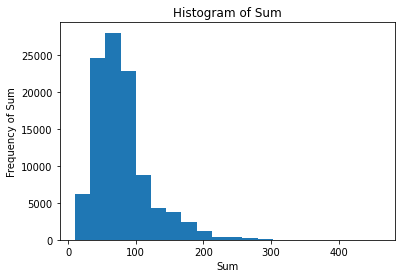

In [0]:
bins, counts = clnt_monthly_aggregations.select('mth_txn_amt_sum').rdd.flatMap(lambda x: x).histogram(20)
plt.hist(bins[:-1], bins=bins, weights=counts)
plt.ylabel('Frequency of Sum')
plt.xlabel('Sum')
plt.title('Histogram of Sum')
plt.show()

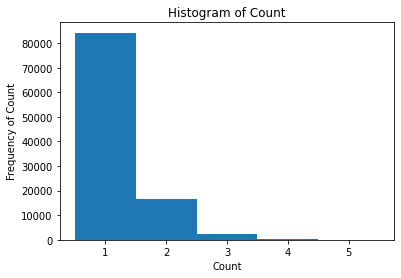

In [0]:
bins, counts = clnt_monthly_aggregations.select('mth_txn_cnt').rdd.flatMap(lambda x: x).histogram(5)
plt.hist(bins[:-1], bins=bins, weights=counts, align = 'left')
plt.ylabel('Frequency of Count')
plt.xlabel('Count')
plt.title('Histogram of Count')
plt.show()

In [0]:
clnt_monthly_aggregations.groupby("mth_txn_amt_sum").count().orderBy("count", ascending=False).show(1)
clnt_monthly_aggregations.groupby("mth_txn_cnt").count().orderBy("count", ascending=False).show(1)

+---------------+-----+
|mth_txn_amt_sum|count|
+---------------+-----+
|             77| 1293|
+---------------+-----+
only showing top 1 row

+-----------+-----+
|mth_txn_cnt|count|
+-----------+-----+
|          1|84247|
+-----------+-----+
only showing top 1 row



In [0]:
clnt_monthly_aggregations.select(max('mth_txn_cnt')).show()
clnt_monthly_aggregations.select(max('mth_txn_amt_sum')).show()

+----------------+
|max(mth_txn_cnt)|
+----------------+
|               6|
+----------------+

+--------------------+
|max(mth_txn_amt_sum)|
+--------------------+
|                 460|
+--------------------+



In [0]:
clnt_monthly_aggregations.select('mth_txn_amt_sum', 'mth_txn_cnt').summary().show()
clnt_annual_aggregations.select('ann_txn_amt_sum', 'ann_txn_cnt').summary().show()

+-------+-----------------+-------------------+
|summary|  mth_txn_amt_sum|        mth_txn_cnt|
+-------+-----------------+-------------------+
|  count|           103234|             103234|
|   mean|78.69489703004824| 1.2108413894647112|
| stddev|41.52915211333621|0.47543703868782294|
|    min|               10|                  1|
|    25%|               50|                  1|
|    50%|               72|                  1|
|    75%|               95|                  1|
|    max|              460|                  6|
+-------+-----------------+-------------------+

+-------+-----------------+-----------------+
|summary|  ann_txn_amt_sum|      ann_txn_cnt|
+-------+-----------------+-----------------+
|  count|            31140|            31140|
|   mean|260.8859666024406|4.014129736673089|
| stddev|171.8922198009184|2.311327035217909|
|    min|               10|                1|
|    25%|              123|                2|
|    50%|              228|                4|
|    75%|

It is clear from the histograms that most clients shop 1 time per month, and people barely shop more than 2 times per month. By the histogram, the average amount of money people spend in a month seems to fall between 50 to 100, and as confirmed above, the summary statistics, it is $78.69.
Compared to the annual spending, most people shop about 4 times, and spend about $260 per year, which seems reasonable if we combine information about shopping times and amount monthly and annually.

## 1.4

### 1.4.1

In [0]:
clnt_no = txn.select('customer_id').distinct()
me_dt = txn.select('ME_DT').distinct()

In [0]:
print(clnt_no.count(), me_dt.count())

6889 47


### 1.4.2 & 1.4.3

In [0]:
base_table_pd = clnt_no.crossJoin(me_dt).sort('customer_id', 'ME_DT').select(col('customer_id').alias('CLNT_NO'), 'ME_DT')

### 1.4.4

In [0]:
base_table_pd.where(base_table_pd.CLNT_NO == 'CS1112').show()

+-------+----------+
|CLNT_NO|     ME_DT|
+-------+----------+
| CS1112|2011-05-31|
| CS1112|2011-06-30|
| CS1112|2011-07-31|
| CS1112|2011-08-31|
| CS1112|2011-09-30|
| CS1112|2011-10-31|
| CS1112|2011-11-30|
| CS1112|2011-12-31|
| CS1112|2012-01-31|
| CS1112|2012-02-29|
| CS1112|2012-03-31|
| CS1112|2012-04-30|
| CS1112|2012-05-31|
| CS1112|2012-06-30|
| CS1112|2012-07-31|
| CS1112|2012-08-31|
| CS1112|2012-09-30|
| CS1112|2012-10-31|
| CS1112|2012-11-30|
| CS1112|2012-12-31|
+-------+----------+
only showing top 20 rows



In [0]:
base_table_pd.where(base_table_pd.CLNT_NO == 'CS1112').count()

Out[232]: 47

In [0]:
base_table_pd.count()

Out[233]: 323783

All dates fall into between the min and max of month-dates, however, the table only shows the date of the end of each month, by the definition of 'ME_DT'. Also, the snapshot of client CS1112 has 47 rows and base_table has 323783 rows, as confirmed above.

## 1.5

### 1.5.1

In [0]:
clnt_monthly_aggregations = clnt_monthly_aggregations.select(col('customer_id').alias('CLNT_NO'), 'ME_DT', 'mth_txn_amt_sum', 'mth_txn_cnt')

In [0]:
joinExpression = clnt_monthly_aggregations['CLNT_NO'] == base_table_pd['CLNT_NO']
joinExpression1 = clnt_monthly_aggregations['ME_DT'] == base_table_pd['ME_DT']

In [0]:
base_clnt_mth = base_table_pd.alias('a').join(clnt_monthly_aggregations.alias('b'), 
                                     joinExpression & joinExpression1, 'left_outer').select("a.CLNT_NO", 'a.ME_DT', 'mth_txn_amt_sum', 'mth_txn_cnt').fillna(0)

In [0]:
base_clnt_mth.count()

Out[237]: 323783

1. Some rows have NaN values because the corresponding client did not make any purchases in that month.

2. I will again fill the NaN values with 0. Logically, as discussed in 1., NaN appears because there is no transaction associated with that client in that month, so this person shopped 0 times, spent 0 dollar, and we fill with 0.

3. Number of rows is 323783, which equals 6889 (clients) * 47 (months), exactly like what I expect.

4. clnt_monthly_aggregations displays the purchases history per client, so it only shows months in which transactions happened, as well as the amount of purchases; while base_clnt_mth shows purchase history per client within the 47-month period of this data, no matter the client makes the transactions or not. Therefore, number of rows for clnt_monthly_aggregations must be less than number of rows of base_clnt_mth, because not all clients make purchases for the full 47 months. Indeed, number of rows for clnt_monthly_aggregations and base_clnt_mth are 103234 and 323783.

### 1.5.2

In [0]:
base_clnt_mth = base_clnt_mth.sort('CLNT_NO', 'ME_DT')
base_clnt_mth.show()

+-------+----------+---------------+-----------+
|CLNT_NO|     ME_DT|mth_txn_amt_sum|mth_txn_cnt|
+-------+----------+---------------+-----------+
| CS1112|2011-05-31|              0|          0|
| CS1112|2011-06-30|             56|          1|
| CS1112|2011-07-31|              0|          0|
| CS1112|2011-08-31|             96|          1|
| CS1112|2011-09-30|              0|          0|
| CS1112|2011-10-31|             60|          1|
| CS1112|2011-11-30|              0|          0|
| CS1112|2011-12-31|              0|          0|
| CS1112|2012-01-31|              0|          0|
| CS1112|2012-02-29|              0|          0|
| CS1112|2012-03-31|              0|          0|
| CS1112|2012-04-30|             56|          1|
| CS1112|2012-05-31|              0|          0|
| CS1112|2012-06-30|             52|          1|
| CS1112|2012-07-31|             81|          1|
| CS1112|2012-08-31|              0|          0|
| CS1112|2012-09-30|             72|          1|
| CS1112|2012-10-31|

### 1.5.3

In [0]:
from pyspark.sql.window import Window

In [0]:
windowSpec3 = Window.partitionBy("CLNT_NO").orderBy(asc("ME_DT")).rowsBetween(-2, 0)
windowSpec6 = Window.partitionBy("CLNT_NO").orderBy(asc("ME_DT")).rowsBetween(-5, 0)
windowSpec12 = Window.partitionBy("CLNT_NO").orderBy(asc("ME_DT")).rowsBetween(-11, 0)

In [0]:
sumAmount3 = sum(col("mth_txn_amt_sum")).over(windowSpec3)
meanAmount3 = mean(col("mth_txn_amt_sum")).over(windowSpec3)
maxAmount3 = max(col("mth_txn_amt_sum")).over(windowSpec3)
sumCount3 = sum(col("mth_txn_cnt")).over(windowSpec3)
meanCount3 = mean(col("mth_txn_cnt")).over(windowSpec3)
maxCount3 = max(col("mth_txn_cnt")).over(windowSpec3)

sumAmount6 = sum(col("mth_txn_amt_sum")).over(windowSpec6)
meanAmount6 = mean(col("mth_txn_amt_sum")).over(windowSpec6)
maxAmount6 = max(col("mth_txn_amt_sum")).over(windowSpec6)
sumCount6 = sum(col("mth_txn_cnt")).over(windowSpec6)
meanCount6 = mean(col("mth_txn_cnt")).over(windowSpec6)
maxCount6 = max(col("mth_txn_cnt")).over(windowSpec6)

sumAmount12 = sum(col("mth_txn_amt_sum")).over(windowSpec12)
meanAmount12 = mean(col("mth_txn_amt_sum")).over(windowSpec12)
maxAmount12 = max(col("mth_txn_amt_sum")).over(windowSpec12)
sumCount12 = sum(col("mth_txn_cnt")).over(windowSpec12)
meanCount12 = mean(col("mth_txn_cnt")).over(windowSpec12)
maxCount12 = max(col("mth_txn_cnt")).over(windowSpec12)

In [0]:
rolling_features_3M = base_clnt_mth.select(
    col("CLNT_NO"),
    col("ME_DT"),
    sumAmount3.alias("mth_txn_amt_sum_sum"),
    meanAmount3.alias("mth_txn_amt_sum_mean"),
    maxAmount3.alias("mth_txn_amt_sum_max"),
    sumCount3.alias("mth_txn_cnt_sum"),
    meanCount3.alias("mth_txn_cnt_mean"),
    maxCount3.alias("mth_txn_cnt_max"))

# Check snapshot
rolling_features_3M.filter(col('CLNT_NO') == 'CS1112').show(5)

+-------+----------+-------------------+--------------------+-------------------+---------------+------------------+---------------+
|CLNT_NO|     ME_DT|mth_txn_amt_sum_sum|mth_txn_amt_sum_mean|mth_txn_amt_sum_max|mth_txn_cnt_sum|  mth_txn_cnt_mean|mth_txn_cnt_max|
+-------+----------+-------------------+--------------------+-------------------+---------------+------------------+---------------+
| CS1112|2011-05-31|                  0|                 0.0|                  0|              0|               0.0|              0|
| CS1112|2011-06-30|                 56|                28.0|                 56|              1|               0.5|              1|
| CS1112|2011-07-31|                 56|  18.666666666666668|                 56|              1|0.3333333333333333|              1|
| CS1112|2011-08-31|                152|  50.666666666666664|                 96|              2|0.6666666666666666|              1|
| CS1112|2011-09-30|                 96|                32.0|        

In [0]:
rolling_features_6M = base_clnt_mth.select(
    col("CLNT_NO"),
    col("ME_DT"),
    sumAmount6.alias("mth_txn_amt_sum_sum"),
    meanAmount6.alias("mth_txn_amt_sum_mean"),
    maxAmount6.alias("mth_txn_amt_sum_max"),
    sumCount6.alias("mth_txn_cnt_sum"),
    meanCount6.alias("mth_txn_cnt_mean"),
    maxCount6.alias("mth_txn_cnt_max"))

rolling_features_6M.show(20)

+-------+----------+-------------------+--------------------+-------------------+---------------+-------------------+---------------+
|CLNT_NO|     ME_DT|mth_txn_amt_sum_sum|mth_txn_amt_sum_mean|mth_txn_amt_sum_max|mth_txn_cnt_sum|   mth_txn_cnt_mean|mth_txn_cnt_max|
+-------+----------+-------------------+--------------------+-------------------+---------------+-------------------+---------------+
| CS1112|2011-05-31|                  0|                 0.0|                  0|              0|                0.0|              0|
| CS1112|2011-06-30|                 56|                28.0|                 56|              1|                0.5|              1|
| CS1112|2011-07-31|                 56|  18.666666666666668|                 56|              1| 0.3333333333333333|              1|
| CS1112|2011-08-31|                152|                38.0|                 96|              2|                0.5|              1|
| CS1112|2011-09-30|                152|                30.4| 

In [0]:
rolling_features_12M = base_clnt_mth.select(
    col("CLNT_NO"),
    col("ME_DT"),
    sumAmount12.alias("mth_txn_amt_sum_sum"),
    meanAmount12.alias("mth_txn_amt_sum_mean"),
    maxAmount12.alias("mth_txn_amt_sum_max"),
    sumCount12.alias("mth_txn_cnt_sum"),
    meanCount12.alias("mth_txn_cnt_mean"),
    maxCount12.alias("mth_txn_cnt_max"))

rolling_features_12M.show(20)

+-------+----------+-------------------+--------------------+-------------------+---------------+-------------------+---------------+
|CLNT_NO|     ME_DT|mth_txn_amt_sum_sum|mth_txn_amt_sum_mean|mth_txn_amt_sum_max|mth_txn_cnt_sum|   mth_txn_cnt_mean|mth_txn_cnt_max|
+-------+----------+-------------------+--------------------+-------------------+---------------+-------------------+---------------+
| CS1112|2011-05-31|                  0|                 0.0|                  0|              0|                0.0|              0|
| CS1112|2011-06-30|                 56|                28.0|                 56|              1|                0.5|              1|
| CS1112|2011-07-31|                 56|  18.666666666666668|                 56|              1| 0.3333333333333333|              1|
| CS1112|2011-08-31|                152|                38.0|                 96|              2|                0.5|              1|
| CS1112|2011-09-30|                152|                30.4| 

There is only 1 row that appears with null values (which is actually filled with 0 by Spark), by the nature of PySpark. There should have been 2, 5, 11 rows appear with NaN values at the beginning of each client for 3, 6 and 12-month windows, respectively. They should have appeard because there wasn't enough observations before them to get the 'rolling' value. For example, for rolling_features_3M, a rolling sum of the previous 2 observations plus itself are required for an observation, so the first two observations do not satisfy this condition, while the third observation does because it has 3 obervations to "roll with". But in Spark this there is only 1 row with null values (which is actually filled with 0 by Spark).

### 1.5.4

In [0]:
joinExpression1 = rolling_features_3M['CLNT_NO'] == rolling_features_6M['CLNT_NO']
joinExpression2 = rolling_features_3M['ME_DT'] == rolling_features_6M['ME_DT']

In [0]:
df3M6M = rolling_features_3M.alias('a').join(rolling_features_6M.alias('b'), 
                                       joinExpression1 & joinExpression2, 'left_outer').select("a.CLNT_NO", 'a.ME_DT',\
                                       rolling_features_3M['mth_txn_amt_sum_sum'].alias('mth_txn_amt_sum_sum_3M'),\
                                       rolling_features_3M['mth_txn_amt_sum_mean'].alias('mth_txn_amt_sum_mean_3M'),\
                                       rolling_features_3M['mth_txn_amt_sum_max'].alias('mth_txn_amt_sum_max_3M'),\
                                       rolling_features_3M['mth_txn_cnt_sum'].alias('mth_txn_cnt_sum_3M'),\
                                       rolling_features_3M['mth_txn_cnt_mean'].alias('mth_txn_cnt_mean_3M'),\
                                       rolling_features_3M['mth_txn_cnt_max'].alias('mth_txn_cnt_max_3M'),\
                                       rolling_features_6M['mth_txn_amt_sum_sum'].alias('mth_txn_amt_sum_sum_6M'),\
                                       rolling_features_6M['mth_txn_amt_sum_mean'].alias('mth_txn_amt_sum_mean_6M'),\
                                       rolling_features_6M['mth_txn_amt_sum_max'].alias('mth_txn_amt_sum_max_6M'),\
                                       rolling_features_6M['mth_txn_cnt_sum'].alias('mth_txn_cnt_sum_6M'),\
                                       rolling_features_6M['mth_txn_cnt_mean'].alias('mth_txn_cnt_mean_6M'),\
                                       rolling_features_6M['mth_txn_cnt_max'].alias('mth_txn_cnt_max_6M'))

In [0]:
joinExpression3 = df3M6M['CLNT_NO'] == rolling_features_12M['CLNT_NO']
joinExpression4 = df3M6M['ME_DT'] == rolling_features_12M['ME_DT']

In [0]:
df3M6M12M = df3M6M.alias('a').join(rolling_features_12M.alias('b'), 
                                       joinExpression1 & joinExpression2, 'left_outer').select("a.CLNT_NO", 'a.ME_DT',\
                                       df3M6M['mth_txn_amt_sum_sum_3M'],\
                                       df3M6M['mth_txn_amt_sum_mean_3M'],\
                                       df3M6M['mth_txn_amt_sum_max_3M'],\
                                       df3M6M['mth_txn_cnt_sum_3M'],\
                                       df3M6M['mth_txn_cnt_mean_3M'],\
                                       df3M6M['mth_txn_cnt_max_3M'],\
                                       df3M6M['mth_txn_amt_sum_sum_6M'],\
                                       df3M6M['mth_txn_amt_sum_mean_6M'],\
                                       df3M6M['mth_txn_amt_sum_max_6M'],\
                                       df3M6M['mth_txn_cnt_sum_6M'],\
                                       df3M6M['mth_txn_cnt_mean_6M'],\
                                       df3M6M['mth_txn_cnt_max_6M'],\
                                       rolling_features_12M['mth_txn_amt_sum_sum'].alias('mth_txn_amt_sum_sum_12M'),\
                                       rolling_features_12M['mth_txn_amt_sum_mean'].alias('mth_txn_amt_sum_mean_12M'),\
                                       rolling_features_12M['mth_txn_amt_sum_max'].alias('mth_txn_amt_sum_max_12M'),\
                                       rolling_features_12M['mth_txn_cnt_sum'].alias('mth_txn_cnt_sum_12M'),\
                                       rolling_features_12M['mth_txn_cnt_mean'].alias('mth_txn_cnt_mean_12M'),\
                                       rolling_features_12M['mth_txn_cnt_max'].alias('mth_txn_cnt_max_12M'))

In [0]:
joinExpression5 = base_clnt_mth['CLNT_NO'] == df3M6M12M['CLNT_NO']
joinExpression6 = base_clnt_mth['ME_DT'] == df3M6M12M['ME_DT']

In [0]:
all_rolling_features = base_clnt_mth.alias('a').join(df3M6M12M.alias('b'), 
                                       joinExpression5 & joinExpression6, 'left_outer').select("b.CLNT_NO", 'b.ME_DT', 'mth_txn_amt_sum', 'mth_txn_cnt',\
                                       df3M6M12M['mth_txn_amt_sum_sum_3M'],\
                                       df3M6M12M['mth_txn_amt_sum_mean_3M'],\
                                       df3M6M12M['mth_txn_amt_sum_max_3M'],\
                                       df3M6M12M['mth_txn_cnt_sum_3M'],\
                                       df3M6M12M['mth_txn_cnt_mean_3M'],\
                                       df3M6M12M['mth_txn_cnt_max_3M'],\
                                       df3M6M12M['mth_txn_amt_sum_sum_6M'],\
                                       df3M6M12M['mth_txn_amt_sum_mean_6M'],\
                                       df3M6M12M['mth_txn_amt_sum_max_6M'],\
                                       df3M6M12M['mth_txn_cnt_sum_6M'],\
                                       df3M6M12M['mth_txn_cnt_mean_6M'],\
                                       df3M6M12M['mth_txn_cnt_max_6M'],\
                                       df3M6M12M['mth_txn_amt_sum_sum_12M'],\
                                       df3M6M12M['mth_txn_amt_sum_mean_12M'],\
                                       df3M6M12M['mth_txn_amt_sum_max_12M'],\
                                       df3M6M12M['mth_txn_cnt_sum_12M'],\
                                       df3M6M12M['mth_txn_cnt_mean_12M'],\
                                       df3M6M12M['mth_txn_cnt_max_12M']).orderBy('CLNT_NO', 'ME_DT')

### 1.5.5

In [0]:
all_rolling_features.count()

Out[251]: 323783

In [0]:
len(all_rolling_features.columns)

Out[252]: 22

The final ouput, all_rolling_features, has 323783 rows and 22 columns, as confirmed above.

In [0]:
all_rolling_features.display()

CLNT_NO,ME_DT,mth_txn_amt_sum,mth_txn_cnt,mth_txn_amt_sum_sum_3M,mth_txn_amt_sum_mean_3M,mth_txn_amt_sum_max_3M,mth_txn_cnt_sum_3M,mth_txn_cnt_mean_3M,mth_txn_cnt_max_3M,mth_txn_amt_sum_sum_6M,mth_txn_amt_sum_mean_6M,mth_txn_amt_sum_max_6M,mth_txn_cnt_sum_6M,mth_txn_cnt_mean_6M,mth_txn_cnt_max_6M,mth_txn_amt_sum_sum_12M,mth_txn_amt_sum_mean_12M,mth_txn_amt_sum_max_12M,mth_txn_cnt_sum_12M,mth_txn_cnt_mean_12M,mth_txn_cnt_max_12M
CS1112,2011-05-31,0,0,0,0.0,0,0,0.0,0,0,0.0,0,0,0.0,0,0,0.0,0,0,0.0,0
CS1112,2011-06-30,56,1,56,28.0,56,1,0.5,1,56,28.0,56,1,0.5,1,56,28.0,56,1,0.5,1
CS1112,2011-07-31,0,0,56,18.666666666666668,56,1,0.3333333333333333,1,56,18.666666666666668,56,1,0.3333333333333333,1,56,18.666666666666668,56,1,0.3333333333333333,1
CS1112,2011-08-31,96,1,152,50.666666666666664,96,2,0.6666666666666666,1,152,38.0,96,2,0.5,1,152,38.0,96,2,0.5,1
CS1112,2011-09-30,0,0,96,32.0,96,1,0.3333333333333333,1,152,30.4,96,2,0.4,1,152,30.4,96,2,0.4,1
CS1112,2011-10-31,60,1,156,52.0,96,2,0.6666666666666666,1,212,35.333333333333336,96,3,0.5,1,212,35.333333333333336,96,3,0.5,1
CS1112,2011-11-30,0,0,60,20.0,60,1,0.3333333333333333,1,212,35.333333333333336,96,3,0.5,1,212,30.285714285714285,96,3,0.42857142857142855,1
CS1112,2011-12-31,0,0,60,20.0,60,1,0.3333333333333333,1,156,26.0,96,2,0.3333333333333333,1,212,26.5,96,3,0.375,1
CS1112,2012-01-31,0,0,0,0.0,0,0,0.0,0,156,26.0,96,2,0.3333333333333333,1,212,23.555555555555557,96,3,0.3333333333333333,1
CS1112,2012-02-29,0,0,0,0.0,0,0,0.0,0,60,10.0,60,1,0.16666666666666666,1,212,21.2,96,3,0.3,1


I used display() option to download the CSV file.

## 1.6

### 1.6.1

In [0]:
txn = txn.withColumn('day_of_the_week', ((dayofweek('txn_date')+5)%7)).withColumn("day_name", date_format(col("txn_date"), "EEEE"))

In [0]:
# Check snapshot
txn.show(4)

+-----------+-----------+----------+----------+----+---------------+---------+
|customer_id|tran_amount|  txn_date|     ME_DT|YEAR|day_of_the_week| day_name|
+-----------+-----------+----------+----------+----+---------------+---------+
|     CS5295|         35|2013-02-11|2013-02-28|2013|              0|   Monday|
|     CS4768|         39|2015-03-15|2015-03-31|2015|              6|   Sunday|
|     CS2122|         52|2013-02-26|2013-02-28|2013|              1|  Tuesday|
|     CS1217|         99|2011-11-16|2011-11-30|2011|              2|Wednesday|
+-----------+-----------+----------+----------+----+---------------+---------+
only showing top 4 rows



### 1.6.2

In [0]:
txn_for_barplot = txn.groupby('day_name').agg(count('day_name').alias('count'))
txn_for_barplot = txn_for_barplot.sort(txn_for_barplot['count'].desc()) # I sorted the dataframe by descending order to better visualize the counts.
txn_for_barplot.show()

+---------+-----+
| day_name|count|
+---------+-----+
|  Tuesday|18031|
|Wednesday|18028|
| Saturday|17929|
|   Monday|17885|
| Thursday|17796|
|   Sunday|17741|
|   Friday|17590|
+---------+-----+



In [0]:
txn_for_barplot.display()

day_name,count
Tuesday,18031
Wednesday,18028
Saturday,17929
Monday,17885
Thursday,17796
Sunday,17741
Friday,17590


### 1.6.3

In [0]:
annual_day_of_week_counts_pivot = txn.groupBy('customer_id', 'YEAR')\
                                     .pivot('day_name')\
                                     .agg(count('tran_amount'))\
                                     .groupBy('customer_id')\
                                     .pivot('YEAR')\
                                     .sum('Friday', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday')\
                                     .orderBy('customer_id')\
                                     .fillna(0)

In [0]:
 annual_day_of_week_counts_pivot = annual_day_of_week_counts_pivot.select(
     'customer_id',\
     annual_day_of_week_counts_pivot['2011_sum(Friday)'].alias('cnt_2011_Friday'),\
     annual_day_of_week_counts_pivot['2011_sum(Monday)'].alias('cnt_2011_Monday'),\
     annual_day_of_week_counts_pivot['2011_sum(Saturday)'].alias('cnt_2011_Saturday'),\
     annual_day_of_week_counts_pivot['2011_sum(Sunday)'].alias('cnt_2011_Sunday'),\
     annual_day_of_week_counts_pivot['2011_sum(Thursday)'].alias('cnt_2011_Thursday'),\
     annual_day_of_week_counts_pivot['2011_sum(Tuesday)'].alias('cnt_2011_Tuesday'),\
     annual_day_of_week_counts_pivot['2011_sum(Wednesday)'].alias('cnt_2011_Wednesday'),\
     annual_day_of_week_counts_pivot['2012_sum(Friday)'].alias('cnt_2012_Friday'),\
     annual_day_of_week_counts_pivot['2012_sum(Monday)'].alias('cnt_2012_Monday'),\
     annual_day_of_week_counts_pivot['2012_sum(Saturday)'].alias('cnt_2012_Saturday'),\
     annual_day_of_week_counts_pivot['2012_sum(Sunday)'].alias('cnt_2012_Sunday'),\
     annual_day_of_week_counts_pivot['2012_sum(Thursday)'].alias('cnt_2012_Thursday'),\
     annual_day_of_week_counts_pivot['2012_sum(Tuesday)'].alias('cnt_2012_Tuesday'),\
     annual_day_of_week_counts_pivot['2012_sum(Wednesday)'].alias('cnt_2012_Wednesday'),\
     annual_day_of_week_counts_pivot['2013_sum(Friday)'].alias('cnt_2013_Friday'),\
     annual_day_of_week_counts_pivot['2013_sum(Monday)'].alias('cnt_2013_Monday'),\
     annual_day_of_week_counts_pivot['2013_sum(Saturday)'].alias('cnt_2013_Saturday'),\
     annual_day_of_week_counts_pivot['2013_sum(Sunday)'].alias('cnt_2013_Sunday'),\
     annual_day_of_week_counts_pivot['2013_sum(Thursday)'].alias('cnt_2013_Thursday'),\
     annual_day_of_week_counts_pivot['2013_sum(Tuesday)'].alias('cnt_2013_Tuesday'),\
     annual_day_of_week_counts_pivot['2013_sum(Wednesday)'].alias('cnt_2013_Wednesday'),\
     annual_day_of_week_counts_pivot['2014_sum(Friday)'].alias('cnt_2014_Friday'),\
     annual_day_of_week_counts_pivot['2014_sum(Monday)'].alias('cnt_2014_Monday'),\
     annual_day_of_week_counts_pivot['2014_sum(Saturday)'].alias('cnt_2014_Saturday'),\
     annual_day_of_week_counts_pivot['2014_sum(Sunday)'].alias('cnt_2014_Sunday'),\
     annual_day_of_week_counts_pivot['2014_sum(Thursday)'].alias('cnt_2014_Thursday'),\
     annual_day_of_week_counts_pivot['2014_sum(Tuesday)'].alias('cnt_2014_Tuesday'),\
     annual_day_of_week_counts_pivot['2014_sum(Wednesday)'].alias('cnt_2014_Wednesday'),\
     annual_day_of_week_counts_pivot['2015_sum(Friday)'].alias('cnt_2015_Friday'),\
     annual_day_of_week_counts_pivot['2015_sum(Monday)'].alias('cnt_2015_Monday'),\
     annual_day_of_week_counts_pivot['2015_sum(Saturday)'].alias('cnt_2015_Saturday'),\
     annual_day_of_week_counts_pivot['2015_sum(Sunday)'].alias('cnt_2015_Sunday'),\
     annual_day_of_week_counts_pivot['2015_sum(Thursday)'].alias('cnt_2015_Thursday'),\
     annual_day_of_week_counts_pivot['2015_sum(Tuesday)'].alias('cnt_2015_Tuesday'),\
     annual_day_of_week_counts_pivot['2015_sum(Wednesday)'].alias('cnt_2015_Wednesday')) 

In [0]:
# Check snapshot
annual_day_of_week_counts_pivot.display()

customer_id,cnt_2011_Friday,cnt_2011_Monday,cnt_2011_Saturday,cnt_2011_Sunday,cnt_2011_Thursday,cnt_2011_Tuesday,cnt_2011_Wednesday,cnt_2012_Friday,cnt_2012_Monday,cnt_2012_Saturday,cnt_2012_Sunday,cnt_2012_Thursday,cnt_2012_Tuesday,cnt_2012_Wednesday,cnt_2013_Friday,cnt_2013_Monday,cnt_2013_Saturday,cnt_2013_Sunday,cnt_2013_Thursday,cnt_2013_Tuesday,cnt_2013_Wednesday,cnt_2014_Friday,cnt_2014_Monday,cnt_2014_Saturday,cnt_2014_Sunday,cnt_2014_Thursday,cnt_2014_Tuesday,cnt_2014_Wednesday,cnt_2015_Friday,cnt_2015_Monday,cnt_2015_Saturday,cnt_2015_Sunday,cnt_2015_Thursday,cnt_2015_Tuesday,cnt_2015_Wednesday
CS1112,1,0,0,1,0,0,1,0,0,1,3,0,1,0,1,1,0,0,0,0,1,0,0,0,0,1,1,1,0,0,0,0,0,0,1
CS1113,1,1,0,1,0,0,0,2,1,0,0,0,1,1,0,1,1,0,0,2,1,0,0,1,0,0,3,0,0,2,0,0,0,0,1
CS1114,0,1,0,1,1,0,2,0,0,1,1,0,0,0,0,1,0,1,2,0,1,1,1,1,1,0,1,1,0,0,0,0,1,0,0
CS1115,0,0,1,1,0,0,1,1,1,0,2,1,1,1,0,1,2,0,2,0,2,0,0,0,0,2,0,2,0,0,0,0,1,0,0
CS1116,1,1,0,0,1,1,0,1,0,0,0,1,1,0,1,0,0,0,0,0,0,3,1,0,1,0,0,0,0,0,0,0,0,0,0
CS1117,1,0,0,0,1,0,1,1,1,0,0,0,0,1,0,2,0,3,0,0,0,0,0,1,1,1,2,1,0,0,0,0,0,0,0
CS1118,0,0,0,0,0,0,2,0,0,0,0,0,1,0,1,0,0,0,0,0,1,1,2,0,3,0,2,1,0,0,1,0,0,0,0
CS1119,0,0,0,0,0,0,0,0,0,0,1,1,1,2,0,0,0,0,1,1,1,2,1,1,0,0,0,2,0,0,0,0,1,0,0
CS1120,1,1,1,0,2,0,0,1,0,0,1,1,1,1,1,1,1,0,1,2,1,0,1,0,0,0,0,0,3,1,2,0,0,0,0
CS1121,0,1,0,0,2,1,0,1,1,1,4,1,1,1,4,0,0,0,0,1,0,0,1,0,2,2,1,0,0,0,0,0,0,1,0


In [0]:
print(annual_day_of_week_counts_pivot.count())
print(annual_day_of_week_counts_pivot.count() == clnt_annual_aggregations_pivot.count())

6889
True


In [0]:
len(annual_day_of_week_counts_pivot.columns) - 1 # Since 'customer_id' counts as a column, too.

Out[262]: 35

Two dataframes have the same number of rows, as confirmed above. 35 features/columns are created in this section.

### 1.6.4

I used display() command to save the CSV file.

### 1.6.5

In [0]:
df1 = txn.groupby('customer_id', 'day_name', 'ME_DT').agg(count("tran_amount").alias("tran_cnt"))
df2 = df1.groupby("customer_id", "ME_DT").pivot("day_name").agg(sum("tran_cnt"))

month_end_date = df2.groupby("customer_id", "ME_DT").agg(
    sum("Friday").alias("cnt_Friday"),
    sum("Monday").alias("cnt_Monday"),
    sum("Saturday").alias("cnt_Saturday"),
    sum("Sunday").alias("cnt_Sunday"),
    sum("Thursday").alias("cnt_Thrusday"),
    sum("Tuesday").alias("cnt_Tuesday"),
    sum("Wednesday").alias("cnt_Wednesday")).orderBy("customer_id").fillna(0).orderBy("customer_id", "ME_DT")

# Check snapshot
month_end_date.show(5)

+-----------+----------+----------+----------+------------+----------+------------+-----------+-------------+
|customer_id|     ME_DT|cnt_Friday|cnt_Monday|cnt_Saturday|cnt_Sunday|cnt_Thrusday|cnt_Tuesday|cnt_Wednesday|
+-----------+----------+----------+----------+------------+----------+------------+-----------+-------------+
|     CS1112|2011-06-30|         0|         0|           0|         0|           0|          0|            1|
|     CS1112|2011-08-31|         1|         0|           0|         0|           0|          0|            0|
|     CS1112|2011-10-31|         0|         0|           0|         1|           0|          0|            0|
|     CS1112|2012-04-30|         0|         0|           0|         1|           0|          0|            0|
|     CS1112|2012-06-30|         0|         0|           0|         1|           0|          0|            0|
+-----------+----------+----------+----------+------------+----------+------------+-----------+-------------+
only showi

### 1.6.6

In [0]:
month_end_date = month_end_date.withColumnRenamed("ME_DT", "ME_DT_1")

joinExpression = (base_table_pd["CLNT_NO"] == month_end_date['customer_id'])
joinExpression1 = (base_table_pd["ME_DT"] == month_end_date['ME_DT_1'])       

mth_day_counts = base_table_pd.join(month_end_date, joinExpression & joinExpression1, how = 'left').fillna(0)
mth_day_counts = mth_day_counts.withColumnRenamed("CLNT_NO", "customer_id").orderBy("customer_id", "ME_DT")

mth_day_counts.display()

customer_id,ME_DT,customer_id,ME_DT_1,cnt_Friday,cnt_Monday,cnt_Saturday,cnt_Sunday,cnt_Thrusday,cnt_Tuesday,cnt_Wednesday
CS6001,2011-05-31,null,null,0,0,0,0,0,0,0
CS3591,2011-05-31,null,null,0,0,0,0,0,0,0
CS5241,2011-05-31,null,null,0,0,0,0,0,0,0
CS3155,2011-05-31,null,null,0,0,0,0,0,0,0
CS2754,2011-05-31,null,null,0,0,0,0,0,0,0
CS5130,2011-05-31,null,null,0,0,0,0,0,0,0
CS3587,2011-05-31,null,null,0,0,0,0,0,0,0
CS2282,2011-05-31,null,null,0,0,0,0,0,0,0
CS1664,2011-05-31,null,null,0,0,0,0,0,0,0
CS1802,2011-05-31,null,null,0,0,0,0,0,0,0


I will impute all NaN values with 0, becuase transactions did not happen in that month, not on Monday, not on Friday and so on, so transactions happened 0 times. But the month exists because we want to show the whole 47 months within this dataset.

## 1.7

### 1.7.1

In [0]:
last_monthly_purchase = txn.groupBy('customer_id', 'ME_DT').agg(max('txn_date').alias('last_month_purchase')).orderBy(txn.customer_id.asc(), txn.ME_DT.asc())

In [0]:
last_monthly_purchase.show()

+-----------+----------+-------------------+
|customer_id|     ME_DT|last_month_purchase|
+-----------+----------+-------------------+
|     CS1112|2011-06-30|         2011-06-15|
|     CS1112|2011-08-31|         2011-08-19|
|     CS1112|2011-10-31|         2011-10-02|
|     CS1112|2012-04-30|         2012-04-08|
|     CS1112|2012-06-30|         2012-06-24|
|     CS1112|2012-07-31|         2012-07-03|
|     CS1112|2012-09-30|         2012-09-16|
|     CS1112|2012-12-31|         2012-12-15|
|     CS1112|2013-03-31|         2013-03-01|
|     CS1112|2013-07-31|         2013-07-01|
|     CS1112|2013-11-30|         2013-11-13|
|     CS1112|2014-04-30|         2014-04-29|
|     CS1112|2014-07-31|         2014-07-16|
|     CS1112|2014-12-31|         2014-12-04|
|     CS1112|2015-01-31|         2015-01-14|
|     CS1113|2011-05-31|         2011-05-27|
|     CS1113|2011-07-31|         2011-07-25|
|     CS1113|2011-10-31|         2011-10-23|
|     CS1113|2012-03-31|         2012-03-30|
|     CS11

### 1.7.2

In [0]:
joinExpression = base_table_pd['CLNT_NO'] == last_monthly_purchase['customer_id']
joinExpression1 = base_table_pd['ME_DT'] == last_monthly_purchase['ME_DT']

In [0]:
last_monthly_purchase_base = base_table_pd.alias('a').join(last_monthly_purchase.alias('b'), joinExpression & joinExpression1, 'left_outer').select("a.CLNT_NO", 'a.ME_DT', 'b.last_month_purchase').fillna(0).orderBy(base_table_pd['CLNT_NO'].asc(), base_table_pd['ME_DT'].asc())

In [0]:
# Check snapshot
last_monthly_purchase_base.show(8)

+-------+----------+-------------------+
|CLNT_NO|     ME_DT|last_month_purchase|
+-------+----------+-------------------+
| CS1112|2011-05-31|               null|
| CS1112|2011-06-30|         2011-06-15|
| CS1112|2011-07-31|               null|
| CS1112|2011-08-31|         2011-08-19|
| CS1112|2011-09-30|               null|
| CS1112|2011-10-31|         2011-10-02|
| CS1112|2011-11-30|               null|
| CS1112|2011-12-31|               null|
+-------+----------+-------------------+
only showing top 8 rows



For one client, it is meaningless for us to fill the NaT values until we reach the first non-NaT value (given the date is ascendingly sorted); and we will impute any NaT values that has a 'last_month_purchase' value(date) before them using the previous value(date).

The reason is we don't impute NaT values until we reach the first non-NaT value(date) is that this person did not make any purchases before that date; and the reason we impute other NaT values after a valid last_month_purchase value appeared using previous value is because this person has made a purchase in the last month (or before), even though this person did not make any purchases this month, so we record this NaT value with the last non NaT value (the last purchase date).

### 1.7.3

In [0]:
WindowSpec = Window\
  .partitionBy("CLNT_NO")\
  .orderBy("ME_DT")\
  .rowsBetween(Window.unboundedPreceding, 0)

In [0]:
Last = last("last_month_purchase", ignorenulls=True).over(WindowSpec)
 
last_monthly_purchase_base = last_monthly_purchase_base.select("a.CLNT_NO", "a.ME_DT", "b.last_month_purchase", Last.alias("days_since_last_txn")).orderBy("CLNT_NO", "ME_DT")
last_monthly_purchase_base.show()

+-------+----------+-------------------+-------------------+
|CLNT_NO|     ME_DT|last_month_purchase|days_since_last_txn|
+-------+----------+-------------------+-------------------+
| CS1112|2011-05-31|               null|               null|
| CS1112|2011-06-30|         2011-06-15|         2011-06-15|
| CS1112|2011-07-31|               null|         2011-06-15|
| CS1112|2011-08-31|         2011-08-19|         2011-08-19|
| CS1112|2011-09-30|               null|         2011-08-19|
| CS1112|2011-10-31|         2011-10-02|         2011-10-02|
| CS1112|2011-11-30|               null|         2011-10-02|
| CS1112|2011-12-31|               null|         2011-10-02|
| CS1112|2012-01-31|               null|         2011-10-02|
| CS1112|2012-02-29|               null|         2011-10-02|
| CS1112|2012-03-31|               null|         2011-10-02|
| CS1112|2012-04-30|         2012-04-08|         2012-04-08|
| CS1112|2012-05-31|               null|         2012-04-08|
| CS1112|2012-06-30|    

### 1.7.4

In [0]:
#last_monthly_purchase_base = last_monthly_purchase_base.drop("b.last_month_purchase").withColumnRenamed("last", "b.last_month_purchase")

last_monthly_purchase_base = last_monthly_purchase_base.withColumn("days_since_last_txn", datediff("ME_DT", "days_since_last_txn"))
last_monthly_purchase_base.show()

+-------+----------+-------------------+-------------------+
|CLNT_NO|     ME_DT|last_month_purchase|days_since_last_txn|
+-------+----------+-------------------+-------------------+
| CS1112|2011-05-31|               null|               null|
| CS1112|2011-06-30|         2011-06-15|                 15|
| CS1112|2011-07-31|               null|                 46|
| CS1112|2011-08-31|         2011-08-19|                 12|
| CS1112|2011-09-30|               null|                 42|
| CS1112|2011-10-31|         2011-10-02|                 29|
| CS1112|2011-11-30|               null|                 59|
| CS1112|2011-12-31|               null|                 90|
| CS1112|2012-01-31|               null|                121|
| CS1112|2012-02-29|               null|                150|
| CS1112|2012-03-31|               null|                181|
| CS1112|2012-04-30|         2012-04-08|                 22|
| CS1112|2012-05-31|               null|                 53|
| CS1112|2012-06-30|    

### 1.7.5

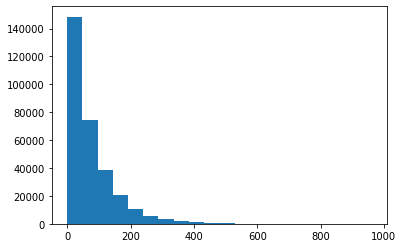

In [0]:
bins, counts = last_monthly_purchase_base.select('days_since_last_txn').rdd.flatMap(lambda x: x).histogram(20)
plt.hist(bins[:-1], bins=bins, weights=counts)
plt.show()

In [0]:
last_monthly_purchase_base_file = last_monthly_purchase_base.select("CLNT_NO", 'ME_DT', 'days_since_last_txn')

In [0]:
last_monthly_purchase_base_file.display()

CLNT_NO,ME_DT,days_since_last_txn
CS1112,2011-05-31,null
CS1112,2011-06-30,15
CS1112,2011-07-31,46
CS1112,2011-08-31,12
CS1112,2011-09-30,42
CS1112,2011-10-31,29
CS1112,2011-11-30,59
CS1112,2011-12-31,90
CS1112,2012-01-31,121
CS1112,2012-02-29,150


I will impute the remaining NaT value with 0, since the person did not make any purchases yet. If we fill it with other positive values, we are saying it has been days since this person made last purchases, whereas this person did not make initial purchases.